# Prepare Environment and Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PROJECT_FOLDER = "/content/drive/MyDrive/Paraphrasing Project"

Mounted at /content/drive


In [ ]:
# download packages
!pip install contractions autocorrect language-tool-python wordcloud swifter

     |████████████████████████████████| 622 kB 5.3 MB/s 
     |████████████████████████████████| 633 kB 31.8 MB/s 
     |████████████████████████████████| 106 kB 41.7 MB/s 
     |████████████████████████████████| 284 kB 50.5 MB/s 
     |████████████████████████████████| 280 kB 43.4 MB/s 
     |████████████████████████████████| 134 kB 46.1 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=31af57de537c285f78771e2b91a2c70adf77620e8d655bab0907bef5927165d5
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
  Created wheel for swifter: filename=swifter-1.1.2-py3-none-any.whl size=13210 sha256=32eae908e6574ee4c2188e3cc9ebfc50aac36e2b1a055c8d11902f546668cca5
  Stored in directory: /root/.cache/pip/wheels/79/7d/d1/9c1daa3e18ead25b4b641491851977b382f4b392a9a32ffc38
Successfully built autocorrect swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninst

In [ ]:
import pandas as pd
import swifter
import numpy as np
import contractions
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from autocorrect import Speller
import language_tool_python
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
import random
random.seed(0)
nltk.download('punkt')

spell = Speller(lang='en')
tool = language_tool_python.LanguageTool('en-US')  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Unzipping /tmp/tmpfqhnrm2e.zip to /root/.cache/language_tool_python.
Downloaded https://www.languagetool.org/download/LanguageTool-5.6.zip to /root/.cache/language_tool_python.


In [ ]:
# download the quora dataset
!curl http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv > quora_duplicate_questions.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.4M  100 55.4M    0     0  91.4M      0 --:--:-- --:--:-- --:--:-- 91.4M


In [ ]:
filename = "quora_duplicate_questions.tsv"
question_pairs_df = pd.read_csv(filename, sep='\t')
question_pairs_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


I only need 2 columns which are [question1] and [question2] with [is_duplicate] == 1

# Basic Text Data Pre-processing

In [ ]:
question_pairs_with_duplicates_only_df = question_pairs_df[question_pairs_df["is_duplicate"]==1].copy()
question_pairs_with_duplicates_only_df.reset_index(drop=True, inplace=True)
question_pairs_with_duplicates_only_df.drop(columns=["id", "qid1","qid2","is_duplicate"], inplace=True)
question_pairs_with_duplicates_only_df.rename(columns={'question1': 'input_sentence', 'question2': 'paraphrased_sentence'}, inplace=True)

In [ ]:
question_pairs_with_duplicates_only_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149263 entries, 0 to 149262
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   input_sentence        149263 non-null  object
 1   paraphrased_sentence  149263 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


The number of examples in the dataset is 149263. \
There is no null value in both of the columns.

# Data Cleaning

In [ ]:
question_pairs_with_duplicates_only_df.head(10)

,input_sentence,paraphrased_sentence
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan..."
1,How can I be a good geologist?,What should I do to be a great geologist?
2,How do I read and find my YouTube comments?,How can I see all my Youtube comments?
3,What can make Physics easy to learn?,How can you make physics easy to learn?
4,What was your first sexual experience like?,What was your first sexual experience?
5,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...
6,What does manipulation mean?,What does manipulation means?
7,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...
8,Why do rockets look white?,Why are rockets and boosters painted white?
9,How should I prepare for CA final law?,How one should know that he/she completely pre...


index 6: The paraphrased_sentence is grammertically wrong. \
It seems like there are a lot of overlapped words between input and paraphrased sentences

In [ ]:
# check whether the sentence has [math] tag
question_pairs_with_duplicates_only_df[question_pairs_with_duplicates_only_df["input_sentence"].apply(lambda s: "[math]" in s)].head(5)

,input_sentence,paraphrased_sentence
8514,How do I learn [math]\LaTeX[/math]?,How can I learn latex in the easiest way?
10950,"Let [math]S_{n} = n^{2} + 20n + 12[/math], whe...",Given [math]S_n = n^2 +20n + 12[/math]. What w...
12249,If real numbers are in [math]x[/math]-axis and...,If the real numbers are usually placed on the ...
27147,How do I solve the problem: [math] A=\begin{pm...,"Given [math]A[/math], What is the general form..."
31400,How can you determine the derivative of [math]...,What is the derivative of [math]\sin \left(x^2...


Without [math] tag in the sentence above, the sentence will have ambiguity such as in index 27147, "[math]A[math]" will be changed to "Given A,..." which doesnt make sense so I decided to not remove it.

In [ ]:
def data_cleaning(example):
  example = example.encode('ascii','ignore').decode(encoding='UTF-8') # decode from ascii to UTF-8
  example = example.strip() # remove leading/trailing space
  example = re.sub(' +', ' ', example) # remove extra space
  example = contractions.fix(example) # expand contractions 
  example = spell(example) # spelling correction
  example = tool.correct(example) # grammer correction
  return example

cleaned_df = question_pairs_with_duplicates_only_df.swifter.applymap(data_cleaning) # swifter to speed up the operation
# delete duplicates if input_sentence is the same as paraphrased senetence
cleaned_df = cleaned_df[cleaned_df["input_sentence"] != cleaned_df["paraphrased_sentence"]].copy()
print("Number of dataset: ", cleaned_df.shape[0])
cleaned_df.to_csv(PROJECT_FOLDER+"/data/cleaned/cleaned_quora_dataset.csv", index = False)

Previous: 149263 \
Now: 148343 \
Proably, those discarded sentences did not really get paraphrased probably at all or the paraphrased sentences is gramatically wrong or spelling incorrect.

In [ ]:
# cluster data by intent
dataset_df = pd.read_csv(PROJECT_FOLDER+"/data/cleaned/cleaned_quora_dataset.csv")
sentence2cluster = {}
clusters = []
duplicates_idxs = []
for index, row in dataset_df.iterrows():
  # in the case where same intent have 2 different clusters, merge these clusters as one
  if row["input_sentence"] in sentence2cluster and row["paraphrased_sentence"] in sentence2cluster:
    if sentence2cluster[row["input_sentence"]] != sentence2cluster[row["paraphrased_sentence"]]:
      clusters[sentence2cluster[row["input_sentence"]]] = set.union(clusters[sentence2cluster[row["input_sentence"]]], clusters[sentence2cluster[row["paraphrased_sentence"]]])
      duplicates_idxs.append(sentence2cluster[row["paraphrased_sentence"]])
      for sentence in clusters[sentence2cluster[row["paraphrased_sentence"]]]:
        sentence2cluster[sentence] = sentence2cluster[row["input_sentence"]]
      sentence2cluster[row["paraphrased_sentence"]] = sentence2cluster[row["input_sentence"]]
  elif row["input_sentence"] in sentence2cluster:
    clusters[sentence2cluster[row["input_sentence"]]].add(row["paraphrased_sentence"])
    sentence2cluster[row["paraphrased_sentence"]] = sentence2cluster[row["input_sentence"]]
  elif row["paraphrased_sentence"] in sentence2cluster:
    clusters[sentence2cluster[row["paraphrased_sentence"]]].add(row["input_sentence"])
    sentence2cluster[row["input_sentence"]] = sentence2cluster[row["paraphrased_sentence"]]
  else:
    clusters.append({row["input_sentence"], row["paraphrased_sentence"]})
    sentence2cluster[row["input_sentence"]] = sentence2cluster[row["paraphrased_sentence"]] = len(clusters) - 1

unique_clusters = []
for i in range(len(clusters)):
  if i not in duplicates_idxs:
    unique_clusters.append(clusters[i])

clusters = unique_clusters

# Prepare train and test dataset

In [ ]:
print("Total size of unique intents:", len(clusters))

random.shuffle(clusters)
train_size = int(len(clusters) * 0.8)
val_size = int(train_size + len(clusters) * 0.1)

train_clusters = clusters[:train_size]
val_clusters = clusters[train_size:val_size]
test_clusters = clusters[val_size:]

# create training dataset
train_input_sentences = []
train_paraphrased_sentences = []
for train_cluster in train_clusters:
  for input_sentence in train_cluster:
    for paraphrased_sentence in train_cluster:
      if input_sentence != paraphrased_sentence:
        train_input_sentences.append(input_sentence)
        train_paraphrased_sentences.append(paraphrased_sentence)
train_df = pd.DataFrame({"input_sentence": train_input_sentences, "paraphrased_sentences": train_paraphrased_sentences})

# create validation dataset
val_input_sentences = []
val_paraphrased_sentences = []
for val_cluster in val_clusters:
  input_sentence = random.choice(list(val_cluster))
  val_cluster.remove(input_sentence)
  val_input_sentences.append(input_sentence)
  val_paraphrased_sentences.append(list(val_cluster))
val_df = pd.DataFrame({"input_sentence": val_input_sentences, "paraphrased_sentences": val_paraphrased_sentences})

# create test dataset
test_input_sentences = []
test_paraphrased_sentences = []
for test_cluster in test_clusters:
  input_sentence = random.choice(list(test_cluster))
  test_cluster.remove(input_sentence)
  test_input_sentences.append(input_sentence)
  test_paraphrased_sentences.append(list(test_cluster))
test_df = pd.DataFrame({"input_sentence": test_input_sentences, "paraphrased_sentences": test_paraphrased_sentences})

# save the train, validation, test dataset
print("Number of examples (Train): ", train_df.shape[0])
print("Number of examples (Validation): ", val_df.shape[0])
print("Number of examples (Test): ", test_df.shape[0])
train_df.to_csv(PROJECT_FOLDER+"/data/cleaned/cleaned_quora_dataset_train.csv", index = False)
val_df.to_csv(PROJECT_FOLDER+"/data/cleaned/cleaned_quora_dataset_val.csv", index = False)
test_df.to_csv(PROJECT_FOLDER+"/data/cleaned/cleaned_quora_dataset_test.csv", index = False)

Total size of unique intents: 59700
Number of examples (Train):  348008
Number of examples (Validation):  5970
Number of examples (Test):  5970


# Data Exploration

In [ ]:
# only analyse training set to avoid data leakage from val and test set
train_df = pd.read_csv(PROJECT_FOLDER+"/data/cleaned/cleaned_quora_dataset_train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348008 entries, 0 to 348007
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   input_sentence         348008 non-null  object
 1   paraphrased_sentences  348008 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


Since input_sentence have the same sentences as paraphrased_sentences, I will only analyse input_sentence.

The most frequent sentence has 96 examples


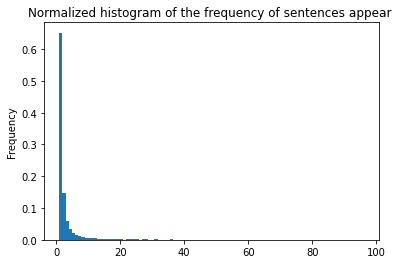

In [ ]:
# normalized histogram of the frequency of sentences appear 
temp_df = train_df.reset_index()
temp_df = train_df["input_sentence"].value_counts()
# check the most frequent sentence
print("The most frequent sentence has", max(temp_df), "examples")
temp_df.plot.hist(title="Normalized histogram of the frequency of sentences appear ",bins=max(temp_df), density=True)

Most of the sentences appear only once 

The longest length of sentence: 90 words


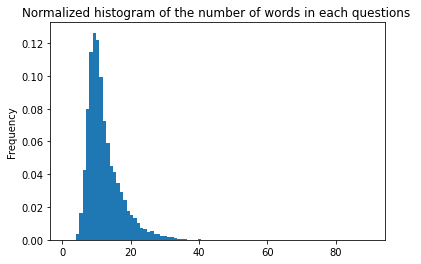

In [ ]:
# normalized histogram of the number of words in each questions
# split the sentences into words
train_df["input_words"] = train_df["input_sentence"].apply(word_tokenize)
train_df["input_words_length"] = train_df["input_words"].apply(lambda s: len(s))
# check the longest length of the sentence
print("The longest length of sentence:", max(train_df["input_words_length"]), "words")
train_df["input_words_length"].plot.hist(title="Normalized histogram of the number of words in each questions ",bins=max(train_df["input_words_length"]), density=True)

Most of sentences has around 10 words on average

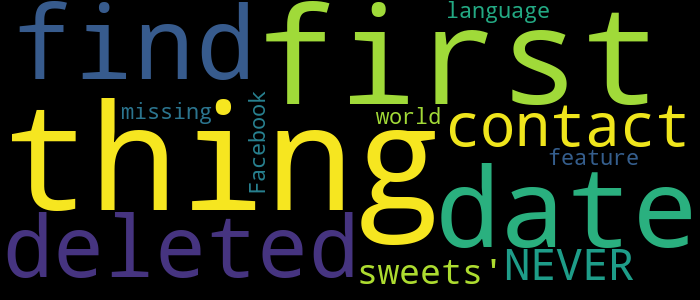

In [ ]:
# Generate a word cloud image to check the most common word
wordcloud = WordCloud(width=700, height=300).generate(str(train_df["input_sentence"].values))
wordcloud.to_image()

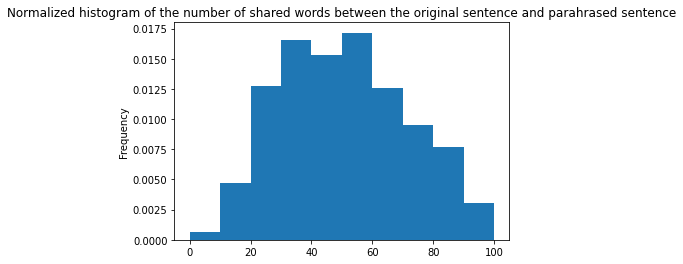

In [ ]:
# normalized histogram of shared word between question1 and question2
# split the sentences into words
train_df["paraphrased_words"] = train_df["paraphrased_sentences"].apply(word_tokenize)
temp_df = pd.DataFrame()
temp_df["input_words"] = train_df["input_words"].apply(set)
temp_df["paraphrased_words"] = train_df["paraphrased_words"].apply(set)
temp_df["input_words_length"] = temp_df["input_words"].apply(lambda s: len(s))
temp_df["paraphrased_words_length"] = temp_df["paraphrased_words"].apply(lambda s: len(s))
temp_df["shared_words"] = temp_df["input_words"] - (temp_df["input_words"] - temp_df["paraphrased_words"])
temp_df["num_of_shared_words"] = temp_df["shared_words"].apply(lambda s: len(s))
temp_df["norm_num_of_shared_words"] = temp_df["num_of_shared_words"] *100/ temp_df[["input_words_length","paraphrased_words_length"]].max(axis=1)
temp_df["norm_num_of_shared_words"].plot.hist(title="Normalized histogram of the number of shared words between the original sentence and parahrased sentence",
                                              bins=10, density=True)

Most of the paraphrased sentences are around 50% similiar with the original sentences. 

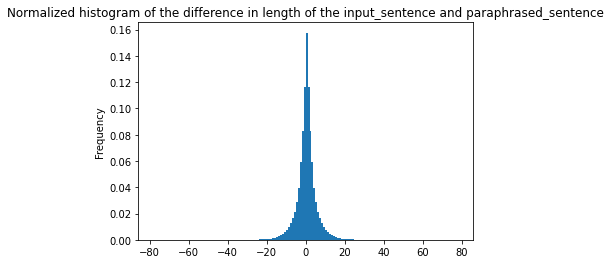

In [ ]:
# normalized histogram of the difference in length of the input_sentence and paraphrased_sentence
train_df["diff_in_length"] = train_df["input_words"].apply(lambda s: len(s)) - train_df["paraphrased_words"].apply(lambda s: len(s))
train_df["diff_in_length"].plot.hist(title="Normalized histogram of the difference in length of the input_sentence and paraphrased_sentence", 
                                     bins=max(train_df["diff_in_length"])-min(train_df["diff_in_length"]),density=True)

Mostly, both of the sentences do not have much difference in length.

In [ ]:
qmarks = np.mean(train_df["input_sentence"].apply(lambda x: x.endswith("?")))
fullstop = np.mean(train_df["input_sentence"].apply(lambda x: x.endswith(".")))
numbers = np.mean(train_df["input_sentence"].apply(lambda x: max([y.isdigit() for y in x])))
print("Total number of unique sentences in the training data:", round(len(train_df["input_sentence"].unique())*100/train_df["input_sentence"].shape[0],2),"%") 
print("Total number of questions in the training data:", round(qmarks*100,2),"%") 
print("Total number of statement sentences in the training data:", round(fullstop*100,2),"%") 
print("Total number of sentences that has digits in the training data:", round(numbers*100,2),"%") 

Total number of unique sentences in the training data: 33.94 %
Total number of questions in the training data: 99.06 %
Total number of statement sentences in the training data: 0.42 %
Total number of sentences that has digits in the training data: 14.59 %


Quora dataset is full of questions but less statement sentences

# Data Augmentation

In [ ]:
# augment data by swapping input and target sentence